In [1]:
from pyspark.sql import SparkSession
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pyspark.ml import PipelineModel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from decimal import Decimal, ROUND_HALF_UP
import matplotlib.pyplot as plt

In [2]:
# Démarrer une session Spark
spark = SparkSession.builder.appName("ModelDay").getOrCreate()

# Lire le CSV depuis HDFS ou local
df = spark.read.option("header", "true").csv("hdfs://localhost:9000/projet/gold/train_df")


25/05/26 00:19:53 WARN Utils: Your hostname, toma-Nitro-AN517-52 resolves to a loopback address: 127.0.1.1; using 192.168.88.15 instead (on interface wlp0s20f3)
25/05/26 00:19:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/26 00:19:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
loaded_pipeline_model = PipelineModel.load("/home/toma/Documents/BIGDATA/big_data_pipeline_v3")
df = loaded_pipeline_model.transform(df)


In [4]:
features = [
    "Days for shipping (real)",
    "Days for shipment (scheduled)",
    "Shipping Mode",
    "order_city",
    "customer_city",
    "Product Card Id",
    "market",
    "late_delivery_risk"
]
features = [col.lower().replace(" ", "_") for col in features]

dfs = df.select(features)

In [5]:
model = PipelineModel.load("/home/toma/Documents/BIGDATA/day_pipeline")
dfs = model.transform(dfs)
dfs = dfs.drop("market", "shipping_mode", "order_city", "customer_city")
dfs.show(10)  # Afficher les 5 premières lignes du DataFrame

+------------------------+-----------------------------+---------------+------------------+------------+-------------------+----------------+-------------------+
|days_for_shipping_(real)|days_for_shipment_(scheduled)|product_card_id|late_delivery_risk|market_index|shipping_mode_index|order_city_index|customer_city_index|
+------------------------+-----------------------------+---------------+------------------+------------+-------------------+----------------+-------------------+
|                       2|                            4|            957|                 0|         0.0|                0.0|             5.0|              254.0|
|                       3|                            4|           1073|                 0|         0.0|                0.0|           826.0|                1.0|
|                       3|                            4|            403|                 0|         0.0|                0.0|           826.0|                1.0|
|                       3|  

In [11]:
class SupplyChainDataset_D(Dataset):
    def __init__(self, dataframe):
        self.X_cat = dataframe[["market_index", "shipping_mode_index", "order_city_index", "customer_city_index"]].values
        self.X_num = dataframe[["product_card_id", "days_for_shipment_(scheduled)","late_delivery_risk"]].values
        self.y = dataframe["days_for_shipping_(real)"].values

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            "cat": torch.tensor(self.X_cat[idx], dtype=torch.long),
            "num": torch.tensor(self.X_num[idx], dtype=torch.float32),
            "target": torch.tensor(self.y[idx], dtype=torch.float32)
       
        }


In [12]:
class SupplyChainModel_D(nn.Module):
    def __init__(self):
        super().__init__()
        self.market_emb = nn.Embedding(5, 5)
        self.ship_emb = nn.Embedding(4, 4)
        self.order_city_emb = nn.Embedding(3597, 1799)
        self.customer_city_emb = nn.Embedding(563, 282)

        # total embeddings + 3 features numériques
        self.fc1 = nn.Linear(5 + 4 + 1799 + 282 + 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, x_cat, x_num):
        e1 = self.market_emb(x_cat[:, 0])
        e2 = self.ship_emb(x_cat[:, 1])
        e3 = self.order_city_emb(x_cat[:, 2])
        e4 = self.customer_city_emb(x_cat[:, 3])
        x = torch.cat([e1, e2, e3, e4, x_num], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)  # pas de sigmoid ici (BCEWithLogitsLoss s'en charge)


In [9]:
train_df, test_df = dfs.randomSplit([0.6, 0.4], seed=42)
test_df.show(10)  # Afficher les 5 premières lignes du DataFrame

+------------------------+-----------------------------+---------------+------------------+------------+-------------------+----------------+-------------------+
|days_for_shipping_(real)|days_for_shipment_(scheduled)|product_card_id|late_delivery_risk|market_index|shipping_mode_index|order_city_index|customer_city_index|
+------------------------+-----------------------------+---------------+------------------+------------+-------------------+----------------+-------------------+
|                       0|                            0|            116|                 0|         0.0|                3.0|             1.0|                0.0|
|                       0|                            0|            116|                 0|         2.0|                3.0|           244.0|               21.0|
|                       0|                            0|            135|                 0|         0.0|                3.0|            75.0|               30.0|
|                       0|  

In [10]:
def write_to_hdfs(df, path):
    """
    Écrit le DataFrame dans un fichier CSV sur HDFS.
    """
    df.write.mode("overwrite").csv(f"hdfs://localhost:9000/projet/{path}", header=True)

In [11]:
write_to_hdfs(dfs, "sliver/df_Model_day")

In [13]:

dataset = SupplyChainDataset_D(train_df.toPandas())
dataloader = DataLoader(dataset, batch_size=80, shuffle=True)

model = SupplyChainModel_D()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoch_losses = []
# Entraînement
for epoch in range(50):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    for batch in dataloader:
        x_cat = batch["cat"]
        x_num = batch["num"]
        y = batch["target"].unsqueeze(1)  # shape [batch_size, 1]

        y_pred = model(x_cat, x_num)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = y_pred.squeeze().detach()
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())


    rmse = mean_squared_error(all_targets, all_preds, squared=False)
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    epoch_losses.append(epoch_loss)



/home/toma/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/toma/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/toma/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/toma/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

In [14]:
torch.save(model.state_dict(), "day_model_weights_only.pt")

In [ ]:
test_dataset = SupplyChainDataset_D(test_df.toPandas())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [27]:

model = torch.load("day_modal.pt")
model.eval()

predictions = []
targets = []

In [28]:
with torch.no_grad():
    for batch in test_loader:
        x_cat = batch["cat"]
        x_num = batch["num"]
        y_true = batch["target"].unsqueeze(1)

        y_pred = model(x_cat, x_num)
        preds = y_pred.squeeze().detach()
        predictions.append(preds)
        targets.append(y_true)


In [29]:

# Fusionner tous les résultats
predictions = torch.cat(predictions, dim=0).squeeze().numpy()
targets = torch.cat(targets, dim=0).squeeze().numpy()


In [ ]:
def arrondir_classique(nombre):
    return Decimal(str(nombre)).quantize(Decimal('1'), rounding=ROUND_HALF_UP)

predictions = [arrondir_classique(pred) for pred in predictions]

In [30]:
for pred, true in zip(predictions[2500:2550], targets[2500:2550]):
    print(f"Prédit: {pred}, Réel: {true}")



Prédit: 2.7921805381774902, Réel: 2.0
Prédit: 2.8269290924072266, Réel: 2.0
Prédit: 3.272657871246338, Réel: 2.0
Prédit: 3.272657871246338, Réel: 2.0
Prédit: 3.272657871246338, Réel: 2.0
Prédit: 3.4338245391845703, Réel: 2.0
Prédit: 3.595644474029541, Réel: 2.0
Prédit: 3.411163330078125, Réel: 2.0
Prédit: 2.8075242042541504, Réel: 2.0
Prédit: 2.8075242042541504, Réel: 2.0
Prédit: 3.2750000953674316, Réel: 2.0
Prédit: 2.85042667388916, Réel: 2.0
Prédit: 2.8378312587738037, Réel: 2.0
Prédit: 3.1865110397338867, Réel: 2.0
Prédit: 3.2977347373962402, Réel: 2.0
Prédit: 2.9206719398498535, Réel: 2.0
Prédit: 3.0089035034179688, Réel: 2.0
Prédit: 2.7969048023223877, Réel: 2.0
Prédit: 3.584688186645508, Réel: 2.0
Prédit: 2.421600341796875, Réel: 2.0
Prédit: 2.6366662979125977, Réel: 2.0
Prédit: 2.528852939605713, Réel: 2.0
Prédit: 2.496964931488037, Réel: 2.0
Prédit: 3.2306604385375977, Réel: 2.0
Prédit: 2.85794997215271, Réel: 2.0
Prédit: 3.229957103729248, Réel: 2.0
Prédit: 3.388420581817627,

In [31]:
def regression_report(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("📊 Rapport de régression")
    print(f"MAE  (Erreur absolue moyenne) : {mae:.4f}")
    print(f"MSE  (Erreur quadratique moyenne) : {mse:.4f}")
    print(f"RMSE (Racine de l'erreur quadratique moyenne) : {rmse:.4f}")
    print(f"R²   (Coefficient de détermination) : {r2:.4f}")


In [32]:
regression_report(targets, predictions)

📊 Rapport de régression
MAE  (Erreur absolue moyenne) : 0.5174
MSE  (Erreur quadratique moyenne) : 0.5341
RMSE (Racine de l'erreur quadratique moyenne) : 0.7308
R²   (Coefficient de détermination) : 0.7977


/home/toma/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
torch.save(model, "day_modal.pt")

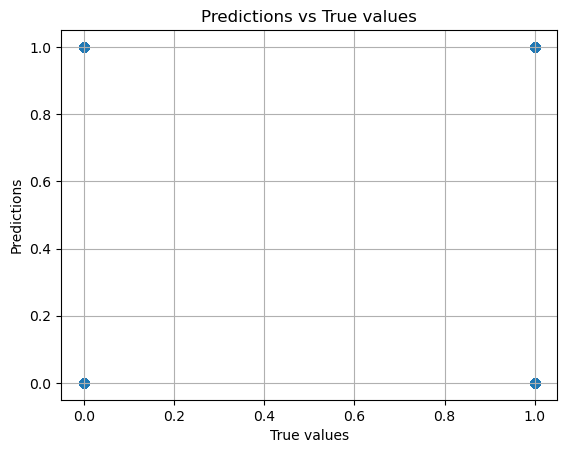

In [ ]:
plt.scatter(targets, predictions, alpha=0.5)
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.title("Predictions vs True values")
plt.grid(True)
plt.show()


In [33]:
epochs = range(1, len(epoch_losses) + 1)
print("Epochs:", epoch_losses)
plt.figure(figsize=(12, 8))

# Courbe de la perte
plt.plot(epochs, epoch_losses, label="Loss")

plt.title("Courbes d'apprentissage")
plt.xlabel("Époque")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'epoch_losses' is not defined

In [ ]:
df.select("product_name").show(10)  # Afficher les 5 premières lignes du DataFrame

In [6]:
spark.stop()